In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from create_matrix import *
import os
import sys
from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse_fraction
from common import compute_rmse

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
year = 2014
n_splits = 10
case=2
a=2
cost='abs'

In [3]:
def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [4]:
def learn_HAT_constant(c, case, E_np_masked, a, b, num_iter=2000, lr=0.1, dis=False, cost_function='abs', H_known=None,
              A_known=None, T_known=None):
    np.random.seed(0)
    if cost_function == 'abs':
        cost = cost_abs
    else:
        cost = cost_rel
    mg = multigrad(cost, argnums=[0, 1, 2])

    params = {}
    params['M'], params['N'], params['O'] = E_np_masked.shape
    params['a'] = a
    params['b'] = b
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)
    H = np.random.rand(*H_dim)

    A = np.random.rand(*A_dim)
    T = np.random.rand(*T_dim)

    T[:,0] = c
    # GD procedure
    for i in range(num_iter):
        del_h, del_a, del_t = mg(H, A, T, E_np_masked, case)
        H -= lr * del_h
        A -= lr * del_a
        T -= lr * del_t
        # Projection to known values
        if H_known is not None:
            H = set_known(H, H_known)
        if A_known is not None:
            A = set_known(A, A_known)
        if T_known is not None:
            T = set_known(T, T_known)
        # Projection to non-negative space
        H[H < 0] = 0
        A[A < 0] = 0
        T[T < 0] = 0
        T[:,0] = c
#         print T
        if i % 500 == 0:
            if dis:
                print(cost(H, A, T, E_np_masked, case))
    return H, A, T


In [5]:
region = "SanDiego"
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)
region = "Austin"
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)

## Normal learning

In [6]:
pred = {}
n_splits = 10
case = 2
a = 2
b = 3
cost = 'abs'

for random_seed in range(5):
    pred[random_seed] = {}
    for appliance in APPLIANCES_ORDER:
        pred[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for random_seed in range(5):
    print "random seed: ", random_seed
    for train_percentage in range(10, 110, 10):
        print "training percentage: ", train_percentage
        rd = 0
        for train_max, test in kf.split(sd_df):
            print "round: ", rd
            rd += 1
            
            num_train = int((train_percentage*len(train_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if train_percentage==100:
                train = train_max
            else:
                train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            train_ix = sd_df.index[train]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            train_test_ix = np.concatenate([test_ix, train_ix])
            df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
            tensor = get_tensor(df_t, dfc_t)
            tensor_copy = tensor.copy()
            # set the appliance consumption to be missing for testing data
            tensor_copy[:num_test, 1:, :] = np.NaN
            # do tensor factorization
            H, A, T = learn_HAT(case, tensor_copy, a, 3, num_iter=2000, lr=0.1, dis=False, cost_function=cost)
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))

random seed:  0
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
training percentage:  20
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
te

## Transfer learning

In [8]:
H_a, A_a, T_a = learn_HAT(case, au_tensor, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost) 
from scipy.optimize import nnls

pred_transfer = {}
T_adapt_transfer = {}

for random_seed in range(5):
    pred_transfer[random_seed] = {}
    T_adapt_transfer[random_seed] = {}
    for appliance in APPLIANCES_ORDER:
        pred_transfer[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for random_seed in range(5):
    print "random seed: ", random_seed
    for adapt_percentage in range(10, 110, 10):
        print "adapt percentage: ", adapt_percentage
        rd = 0
        T_adapt_transfer[random_seed][adapt_percentage] = {}
        for adapt_max, test in kf.split(sd_df):
            print "round: ", rd
            rd += 1
            
            num_adapt = int((adapt_percentage*len(adapt_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if adapt_percentage == 100:
                adapt = adapt_max
            else:
                adapt, _ = train_test_split(adapt_max, train_size = adapt_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            adapt_ix = sd_df.index[adapt]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            adapt_df = sd_df.ix[adapt_ix]
            test_df = sd_df.ix[test_ix]
            adapt_dfc = sd_dfc.ix[adapt_ix]
            test_dfc = sd_dfc.ix[test_ix]
            adapt_sd_tensor = get_tensor(adapt_df, adapt_dfc)
            
            # use the adpat data with A_au from Austion to learn T_sd_adapt
            H_sd_adapt, A_sd_adapt, T_sd_adapt = learn_HAT(case, adapt_sd_tensor, a, 3, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_a)
            T_adapt_transfer[random_seed][adapt_percentage][rd] = T_sd_adapt

            
            # Then we use T_sd_adapt, A_a and aggregate readings to learn H_sd in SanDiego
            test_sd_tensor = get_tensor(test_df, test_dfc)
            # Get the aggregate information of test homes
            aggregate_test = test_sd_tensor[:, 0, :]
            # Use A_au from Austin and T_sd_adapt learn previous
            AT_mat = np.einsum('ab, Ob -> aO', A_a[0], T_sd_adapt)
            
            # Estimate Home factor H_test_mat for test homes
            H_test_mat = np.zeros((len(test_df), 2))
            for j in range(len(test_df)):
                mask_rows = pd.Series(aggregate_test[j,:]).notnull()
                H_test_mat[j,:] = nnls(AT_mat.transpose()[mask_rows], aggregate_test[j,:][mask_rows])[0]
            pred_overall = np.einsum('Ma, Nab, Ob -> MNO', H_test_mat, A_a, T_sd_adapt)
            
            for appliance_name, appliance_id in appliance_index.iteritems():
                pred_transfer[random_seed][appliance_name][adapt_percentage].append(pd.DataFrame(pred_overall[:,appliance_id,:], index=test_df.index))
            

random seed:  0
adapt percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
adapt percentage:  20
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:

## Transfer learning with constant

### C = 10

In [300]:
c = 10
from scipy.optimize import nnls

pred_transfer_cons_10 = {}
T_adapt_cons_10 = {}
H_sd_10 = {}

H_a, A_a_const, T_a = learn_HAT_constant(c, case, au_tensor, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost) 

for random_seed in range(5):
    pred_transfer_cons_10[random_seed] = {}
    T_adapt_cons_10[random_seed] = {}
    H_sd_10[random_seed] = []
    for appliance in APPLIANCES_ORDER:
        pred_transfer_cons_10[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}


kf = KFold(n_splits=n_splits)
for random_seed in range(5):
    print "random seed: ", random_seed
    for adapt_percentage in range(100, 110, 10):
        print "adapt percentage: ", adapt_percentage
        rd = 0
        T_adapt_cons_10[random_seed][adapt_percentage] = {}
        
        for adapt_max, test in kf.split(sd_df):
            print "round: ", rd
            
            
            num_adapt = int((adapt_percentage*len(adapt_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if adapt_percentage == 100:
                adapt = adapt_max
            else:
                adapt, _ = train_test_split(adapt_max, train_size = adapt_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            adapt_ix = sd_df.index[adapt]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            adapt_df = sd_df.ix[adapt_ix]
            test_df = sd_df.ix[test_ix]
            adapt_dfc = sd_dfc.ix[adapt_ix]
            test_dfc = sd_dfc.ix[test_ix]
            adapt_sd_tensor = get_tensor(adapt_df, adapt_dfc)
            
            # use the adpat data with A_au from Austion to learn T_sd_adapt
            H_sd_adapt, A_sd_adapt, T_sd_adapt = learn_HAT_constant(c, case, adapt_sd_tensor, a, 3, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_a_const)

            T_adapt_cons_10[random_seed][adapt_percentage][rd] = T_sd_adapt
            rd += 1
            
            # Then we use T_sd_adapt, A_a and aggregate readings to learn H_sd in SanDiego
            test_sd_tensor = get_tensor(test_df, test_dfc)
            # Get the aggregate information of test homes
            aggregate_test = test_sd_tensor[:, 0, :]
            # Use A_au from Austin and T_sd_adapt learn previous
            AT_mat = np.einsum('ab, Ob -> aO', A_a_const[0], T_sd_adapt)
            
            # Estimate Home factor H_test_mat for test homes
            H_test_mat = np.zeros((len(test_df), 2))
            for j in range(len(test_df)):
                mask_rows = pd.Series(aggregate_test[j,:]).notnull()
                H_test_mat[j,:] = nnls(AT_mat.transpose()[mask_rows], aggregate_test[j,:][mask_rows])[0]
            pred_overall = np.einsum('Ma, Nab, Ob -> MNO', H_test_mat, A_a_const, T_sd_adapt)
            H_sd_10[random_seed].append(pd.DataFrame(H_test_mat, index=test_ix))
            
            for appliance_name, appliance_id in appliance_index.iteritems():
                pred_transfer_cons_10[random_seed][appliance_name][adapt_percentage].append(pd.DataFrame(pred_overall[:,appliance_id,:], index=test_df.index))

random seed:  0
adapt percentage:  100
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
random seed:  1
adapt percentage:  100
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')


### c = 1

In [302]:
c = 1
from scipy.optimize import nnls

pred_transfer_cons_1 = {}
T_adapt_cons_1 = {}
H_sd_1 = {}

H_a, A_a_const, T_a = learn_HAT_constant(c, case, au_tensor, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost) 

for random_seed in range(5):
    pred_transfer_cons_1[random_seed] = {}
    T_adapt_cons_1[random_seed] = {}
    H_sd_1[random_seed] = []
    for appliance in APPLIANCES_ORDER:
        pred_transfer_cons_1[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}


kf = KFold(n_splits=n_splits)
for random_seed in range(5):
    print "random seed: ", random_seed
    for adapt_percentage in range(100, 110, 10):
        print "adapt percentage: ", adapt_percentage
        rd = 0
        T_adapt_cons_1[random_seed][adapt_percentage] = {}
        for adapt_max, test in kf.split(sd_df):
            print "round: ", rd
            
            
            num_adapt = int((adapt_percentage*len(adapt_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if adapt_percentage == 100:
                adapt = adapt_max
            else:
                adapt, _ = train_test_split(adapt_max, train_size = adapt_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            adapt_ix = sd_df.index[adapt]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            adapt_df = sd_df.ix[adapt_ix]
            test_df = sd_df.ix[test_ix]
            adapt_dfc = sd_dfc.ix[adapt_ix]
            test_dfc = sd_dfc.ix[test_ix]
            adapt_sd_tensor = get_tensor(adapt_df, adapt_dfc)
            
            # use the adpat data with A_au from Austion to learn T_sd_adapt
            H_sd_adapt, A_sd_adapt, T_sd_adapt = learn_HAT_constant(c, case, adapt_sd_tensor, a, 3, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_a_const)

            T_adapt_cons_1[random_seed][adapt_percentage][rd] = T_sd_adapt
            rd += 1
            
            # Then we use T_sd_adapt, A_a and aggregate readings to learn H_sd in SanDiego
            test_sd_tensor = get_tensor(test_df, test_dfc)
            # Get the aggregate information of test homes
            aggregate_test = test_sd_tensor[:, 0, :]
            # Use A_au from Austin and T_sd_adapt learn previous
            AT_mat = np.einsum('ab, Ob -> aO', A_a_const[0], T_sd_adapt)
            
            # Estimate Home factor H_test_mat for test homes
            H_test_mat = np.zeros((len(test_df), 2))
            for j in range(len(test_df)):
                mask_rows = pd.Series(aggregate_test[j,:]).notnull()
                H_test_mat[j,:] = nnls(AT_mat.transpose()[mask_rows], aggregate_test[j,:][mask_rows])[0]
            pred_overall = np.einsum('Ma, Nab, Ob -> MNO', H_test_mat, A_a_const, T_sd_adapt)
            H_sd_1[random_seed].append(pd.DataFrame(H_test_mat, index=test_ix))
            
            for appliance_name, appliance_id in appliance_index.iteritems():
                pred_transfer_cons_1[random_seed][appliance_name][adapt_percentage].append(pd.DataFrame(pred_overall[:,appliance_id,:], index=test_df.index))

random seed:  0
adapt percentage:  100
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
random seed:  1
adapt percentage:  100
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')


### c = 0.1

In [307]:
c = 0.1
from scipy.optimize import nnls

pred_transfer_cons_01 = {}
T_adapt_cons_01 = {}
H_sd_01 = {}

H_a, A_a_const, T_a = learn_HAT_constant(c, case, au_tensor, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost) 

for random_seed in range(5):
    pred_transfer_cons_01[random_seed] = {}
    T_adapt_cons_01[random_seed] = {}
    H_sd_01[random_seed] = []
    for appliance in APPLIANCES_ORDER:
        pred_transfer_cons_01[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}


kf = KFold(n_splits=n_splits)
for random_seed in range(5):
    print "random seed: ", random_seed
    for adapt_percentage in range(100, 110, 10):
        print "adapt percentage: ", adapt_percentage
        rd = 0
        T_adapt_cons_01[random_seed][adapt_percentage] = {}
        for adapt_max, test in kf.split(sd_df):
            print "round: ", rd
            
            
            num_adapt = int((adapt_percentage*len(adapt_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if adapt_percentage == 100:
                adapt = adapt_max
            else:
                adapt, _ = train_test_split(adapt_max, train_size = adapt_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            adapt_ix = sd_df.index[adapt]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            adapt_df = sd_df.ix[adapt_ix]
            test_df = sd_df.ix[test_ix]
            adapt_dfc = sd_dfc.ix[adapt_ix]
            test_dfc = sd_dfc.ix[test_ix]
            adapt_sd_tensor = get_tensor(adapt_df, adapt_dfc)
            
            # use the adpat data with A_au from Austion to learn T_sd_adapt
            H_sd_adapt, A_sd_adapt, T_sd_adapt = learn_HAT_constant(c, case, adapt_sd_tensor, a, 3, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_a_const)

            T_adapt_cons_01[random_seed][adapt_percentage][rd] = T_sd_adapt
            rd += 1
            
            # Then we use T_sd_adapt, A_a and aggregate readings to learn H_sd in SanDiego
            test_sd_tensor = get_tensor(test_df, test_dfc)
            # Get the aggregate information of test homes
            aggregate_test = test_sd_tensor[:, 0, :]
            # Use A_au from Austin and T_sd_adapt learn previous
            AT_mat = np.einsum('ab, Ob -> aO', A_a_const[0], T_sd_adapt)
            
            # Estimate Home factor H_test_mat for test homes
            H_test_mat = np.zeros((len(test_df), 2))
            for j in range(len(test_df)):
                mask_rows = pd.Series(aggregate_test[j,:]).notnull()
                H_test_mat[j,:] = nnls(AT_mat.transpose()[mask_rows], aggregate_test[j,:][mask_rows])[0]
            pred_overall = np.einsum('Ma, Nab, Ob -> MNO', H_test_mat, A_a_const, T_sd_adapt)
            H_sd_01[random_seed].append(pd.DataFrame(H_test_mat, index=test_ix))
            
            for appliance_name, appliance_id in appliance_index.iteritems():
                pred_transfer_cons_01[random_seed][appliance_name][adapt_percentage].append(pd.DataFrame(pred_overall[:,appliance_id,:], index=test_df.index))

random seed:  0
adapt percentage:  100
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
random seed:  1
adapt percentage:  100
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')


In [308]:
H_sd_01[0][0]

,0,1
54,0.868160,2.236147
203,0.515440,3.437174
527,0.000000,8.571491
1450,1.835667,5.823884


In [309]:
H_sd_1[0][0]

,0,1
54,1.003446,2.251892
203,0.600810,3.484148
527,0.000000,8.729764
1450,2.127926,5.869243


In [310]:
H_sd_10[0][0]

,0,1
54,0.217799,1.605264
203,0.112935,2.127942
527,1.476533,2.813665
1450,0.370713,4.141677


In [31]:
out_transfer_cons_10 = {}
for random_seed in range(5):
    out_transfer_cons_10[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_transfer_cons_10[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_transfer_cons_10[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_transfer_cons_10[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_transfer_cons_10[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [32]:
out_transfer_cons_1 = {}
for random_seed in range(5):
    out_transfer_cons_1[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_transfer_cons_1[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_transfer_cons_1[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_transfer_cons_1[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_transfer_cons_1[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [33]:
out_transfer_cons_01 = {}
for random_seed in range(5):
    out_transfer_cons_01[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_transfer_cons_01[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_transfer_cons_01[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_transfer_cons_01[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_transfer_cons_01[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [34]:
out_transfer = {}
for random_seed in range(5):
    out_transfer[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_transfer[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_transfer[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_transfer[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_transfer[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [35]:
out = {}
for random_seed in range(5):
    out[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [36]:
mean_out_transfer_const_10 = pd.Panel(out_transfer_cons_10).mean(axis=0)
std_out_transfer_const_10 = pd.Panel(out_transfer_cons_10).std(axis=0).values
sum_out_transfer_const_10 = mean_out_transfer_const_10.sum(axis=1)

mean_out_transfer_const_1 = pd.Panel(out_transfer_cons_1).mean(axis=0)
std_out_transfer_const_1 = pd.Panel(out_transfer_cons_1).std(axis=0).values
sum_out_transfer_const_1 = mean_out_transfer_const_1.sum(axis=1)

mean_out_transfer_const_01 = pd.Panel(out_transfer_cons_01).mean(axis=0)
std_out_transfer_const_01 = pd.Panel(out_transfer_cons_01).std(axis=0).values
sum_out_transfer_const_01 = mean_out_transfer_const_01.sum(axis=1)

mean_out_transfer = pd.Panel(out_transfer).mean(axis=0)
mean_out_normal = pd.Panel(out).mean(axis=0)
std_out_normal = pd.Panel(out).std(axis=0).values
std_out_transfer = pd.Panel(out_transfer).std(axis=0).values
sum_out_transfer = mean_out_transfer.sum(axis=1)
sum_out_normal = mean_out_normal.sum(axis=1)

In [315]:
# df_out_normal = pd.DataFrame(out_normal)]
mean_out_normal = mean_out_normal.rename(columns={'dw':'dw_normal', 'fridge':'fridge_normal', 'hvac':'hvac_normal',
                                             'mw':'mw_normal', 'oven':"oven_normal", 'wm':'wm_normal'})
# mean_out_normal_const = mean_out_normal_const.rename(columns={'dw':'dw_normal_const', 'fridge':'fridge_normal_const', 'hvac':'hvac_normal_const',
#                                              'mw':'mw_normal_const', 'oven':"oven_normal_const", 'wm':'wm_normal_const'})
mean_out_transfer = mean_out_transfer.rename(columns={'dw':'dw_transfer', 'fridge':'fridge_transfer', 'hvac':'hvac_transfer',
                                             'mw':'mw_transfer', 'oven':"oven_transfer", 'wm':'wm_transfer'})
mean_out_transfer_const = mean_out_transfer_const_1.rename(columns={'dw':'dw_transfer_const', 'fridge':'fridge_transfer_const', 'hvac':'hvac_transfer_const',
                                             'mw':'mw_transfer_const', 'oven':"oven_transfer_const", 'wm':'wm_transfer_const'})

all_out = pd.concat([mean_out_normal, mean_out_transfer, mean_out_transfer_const], axis=1)
# all_out = pd.concat([mean_out_normal, mean_out_transfer], axis=1)
# all_out = pd.concat([all_out, mean_out_transfer_const], axis=1)
# all_out = pd.concat([all_out, mean_out_normal_const], axis=1)



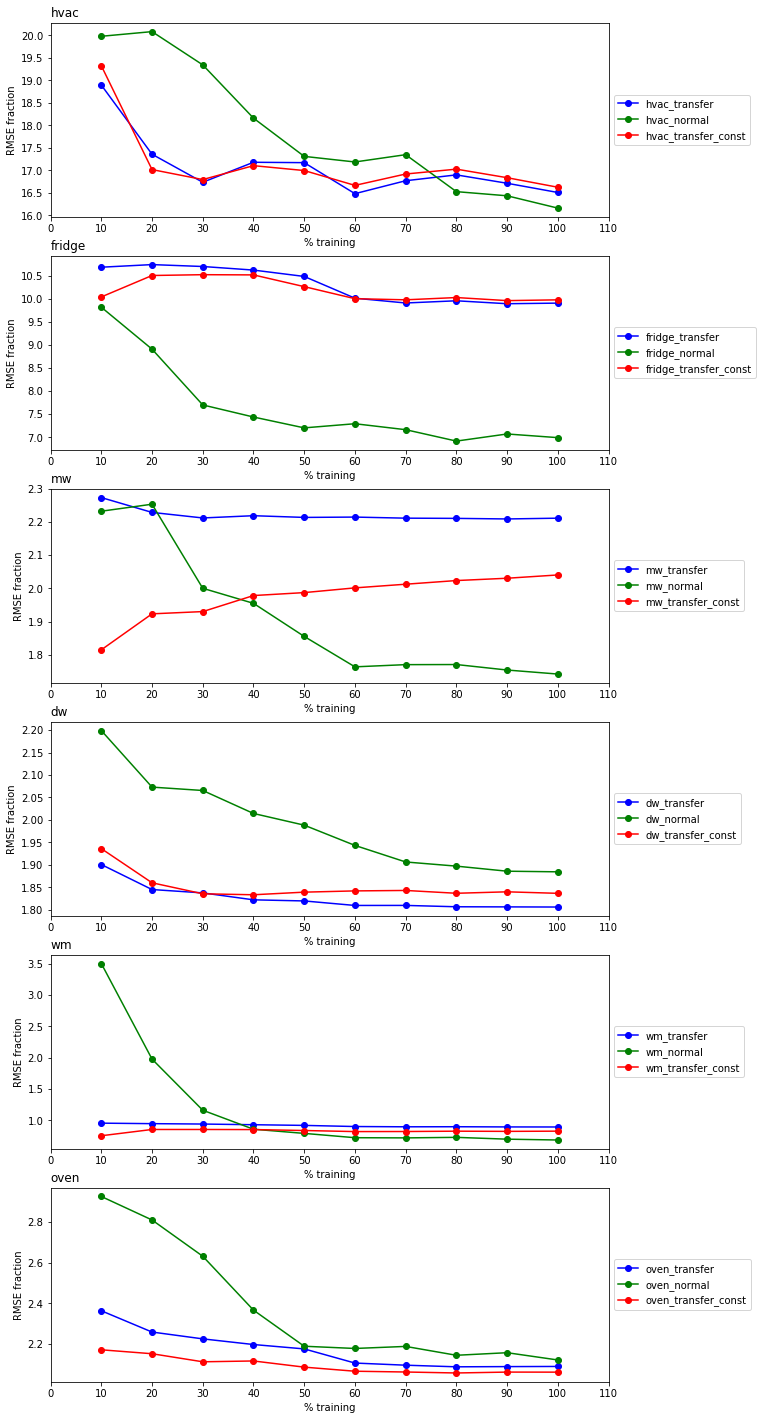

In [45]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 15))
ax = axes.flatten()
count = 0


# df['A'].plot(ax=axes[0,0]); axes[0,0].set_title('A')
for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
    df1 = all_out[appliance+ '_transfer']
    df2 = all_out[appliance+ '_normal']
    df3 = all_out[appliance+ '_transfer_const']
#     df4 = all_out[appliance+ '_normal_const']
# df4 = all_out[appliance+ '_agg_2']
# df5 = all_out[appliance+ '_agg_3']
# df6 = all_out[appliance+ '_agg_4']
# df7 = all_out[appliance+ '_reg']
    df = pd.concat([df1, df2, df3], axis=1)
#     ax[count].plot(df)
    pd.DataFrame(df).plot(ax=ax[count],figsize=(10, 25), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


#     major_ticks = np.arange(0, 101, 20)   

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_ylabel('RMSE fraction')
    ax[count].set_title(appliance, loc="left")
    count += 1
plt.savefig("./analysis/transfer_const_1_628.png", bbox_inches="tight", dpi=300)

In [321]:
T_adapt_transfer[0][100]

{1: array([[ 0.        ,  5.74131583,  0.        ],
        [ 0.        ,  4.87191905,  0.        ],
        [ 0.        ,  5.39821785,  0.        ],
        [ 0.84491158,  5.09108848,  0.        ],
        [ 2.94385591,  3.8018483 ,  0.95398361],
        [ 3.06506987,  4.03938888,  0.        ],
        [ 3.82447334,  3.10344457,  2.1435593 ],
        [ 6.76755801,  2.47181362,  1.27331919],
        [ 2.68015079,  3.61302851,  3.66060796],
        [ 2.73522723,  4.72907298,  0.47440155],
        [ 0.        ,  5.60878806,  0.        ],
        [ 0.        ,  6.26050943,  0.        ]]),
 2: array([[ 0.        ,  5.43843699,  0.        ],
        [ 0.        ,  4.93475165,  0.        ],
        [ 0.        ,  5.45034171,  0.        ],
        [ 0.69643046,  5.24509063,  0.        ],
        [ 3.14417089,  3.9721283 ,  0.81818339],
        [ 3.82686843,  4.07762712,  0.        ],
        [ 3.77741184,  3.34280751,  2.05754261],
        [ 4.37060273,  3.05009852,  2.48307491],
        [ 0.

## --------------------------------------------------------
## Seasonal Factors analysis

In [322]:
T_01 = []
T_1 = []
T_10 = []
T_transfer = []
for per in range(100, 110, 10):
    temp_01 = 0
    temp_1 = 0
    temp_10 = 0
    temp_transfer = 0
    for random_seed in range(5):
        for rd in range(10):
            temp_01 += T_adapt_cons_01[random_seed][per][rd]
            temp_1 += T_adapt_cons_1[random_seed][per][rd]
            temp_10 += T_adapt_cons_10[random_seed][per][rd]
            temp_transfer += T_adapt_transfer[random_seed][per][rd+1]
    temp_01 = temp_01/50
    temp_1 = temp_1/50
    temp_10 = temp_10/50
    temp_transfer = temp_transfer/50
    T_01.append(temp_01)
    T_1.append(temp_1)
    T_10.append(temp_10)
    T_transfer.append(temp_transfer)

In [324]:
T_transfer

[array([[ 0.        ,  5.37184973,  0.        ],
        [ 0.        ,  4.71839973,  0.        ],
        [ 0.00847704,  5.19591902,  0.        ],
        [ 0.75164122,  5.05833337,  0.        ],
        [ 3.37251132,  3.80409437,  0.87987838],
        [ 3.57615996,  4.10070393,  0.        ],
        [ 4.36788822,  3.00940749,  2.16822059],
        [ 6.03027016,  2.59701038,  2.01286436],
        [ 2.29331275,  3.53454353,  4.17460557],
        [ 2.39225864,  4.75951604,  0.81207818],
        [ 0.02590021,  5.58769903,  0.        ],
        [ 0.08106997,  6.39680114,  0.        ]])]

In [323]:
temp = np.c_[T_01[0], T_1[0], T_10[0], T_transfer[0]]
df = pd.DataFrame(temp)
df = df.rename(columns={0:"factor0, c=0.1", 1:"factor1, c=0.1", 2:"factor2, c=0.1", 
                                3:"factor0, c=1", 4:"factor1, c=1", 5:"factor2, c=1", 
                                6:"factor0, c=10", 7:"factor1, c=10", 8:"factor2, c=10",
                               9:"factor0, no constant", 10: "factor1, no constant", 11:"factor2, no constant"})
df

,"factor0, c=0.1","factor1, c=0.1","factor2, c=0.1","factor0, c=1","factor1, c=1","factor2, c=1","factor0, c=10","factor1, c=10","factor2, c=10","factor0, no constant","factor1, no constant","factor2, no constant"
0,0.1,5.453397,0.000000,1.0,4.608581,0.000000,10.0,0.015551,0.019555,0.000000,5.371850,0.000000
1,0.1,4.785499,0.000000,1.0,3.987874,0.000000,10.0,0.006601,0.007493,0.000000,4.718400,0.000000
2,0.1,5.279679,0.000038,1.0,4.438395,0.000000,10.0,0.009673,0.011947,0.008477,5.195919,0.000000
3,0.1,5.296967,0.295500,1.0,4.443146,0.295132,10.0,0.022764,0.038656,0.751641,5.058333,0.000000
4,0.1,4.460212,2.201351,1.0,3.632600,2.182404,10.0,0.029017,2.991313,3.372511,3.804094,0.879878
5,0.1,4.869397,1.459826,1.0,4.008033,1.456831,10.0,0.027566,1.844490,3.576160,4.100704,0.000000
6,0.1,3.858099,3.751448,1.0,3.043814,3.719252,10.0,0.059284,5.433486,4.367888,3.009407,2.168221
7,0.1,3.696568,4.347589,1.0,2.881505,4.308429,10.0,0.373920,6.364257,6.030270,2.597010,2.012864
8,0.1,4.039364,4.645223,1.0,3.210204,4.598908,10.0,1.684946,6.467168,2.293313,3.534544,4.174606
9,0.1,5.239067,1.736585,1.0,4.366759,1.721933,10.0,0.030271,2.661267,2.392259,4.759516,0.812078


IndexError: list index out of range

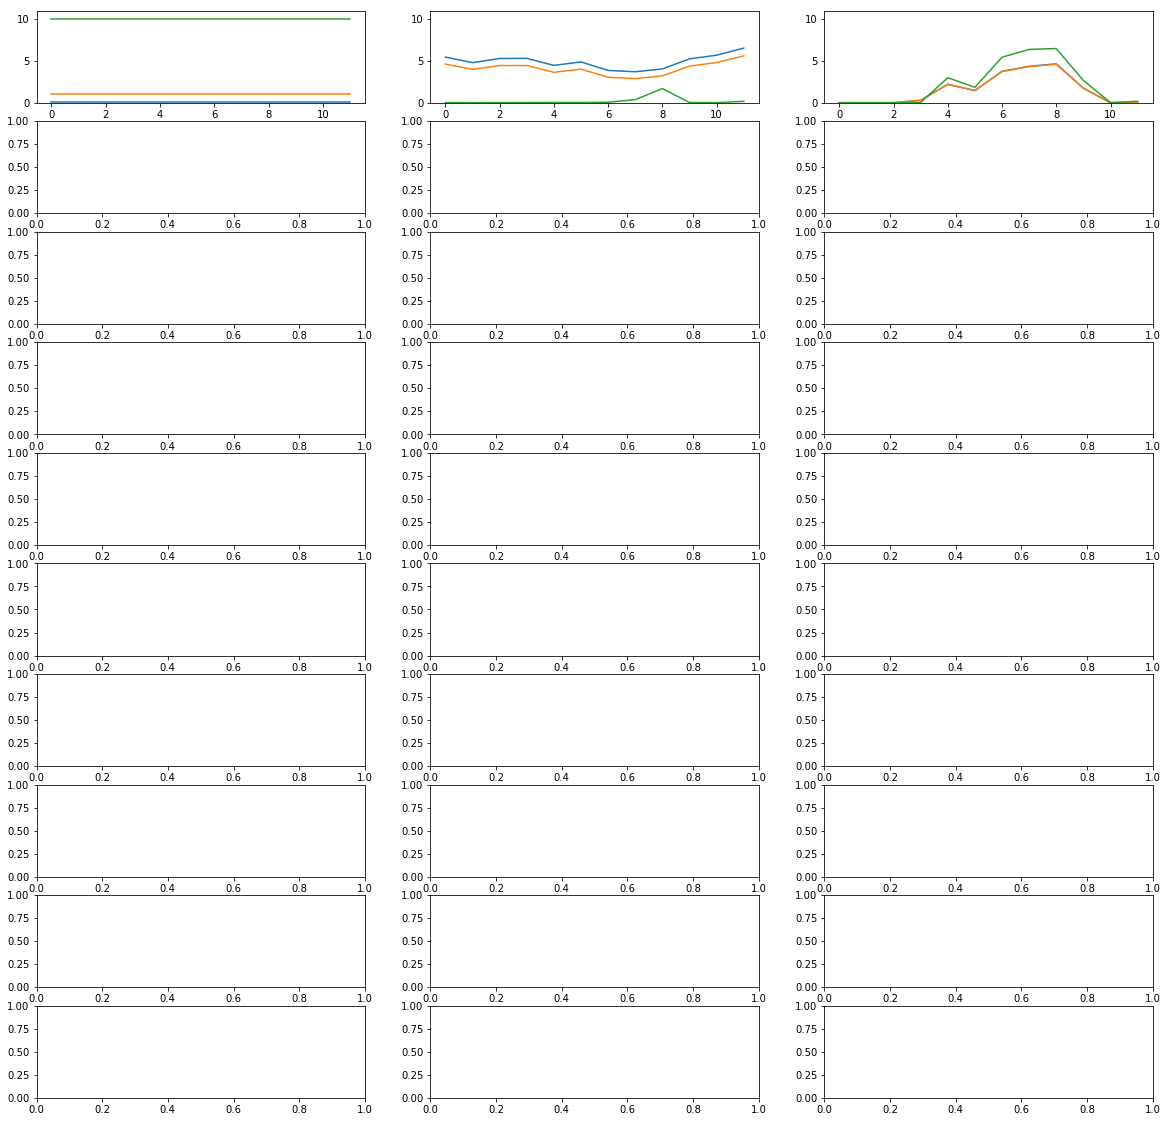

In [325]:
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(20, 20))
# ax = axes.flatten()
count = 0

for i in range(10):
    temp = np.c_[T_01[i], T_1[i], T_10[i], T_transfer[0]]
    df = pd.DataFrame(temp)
    df = df.rename(columns={0:"factor0, c=0.1", 1:"factor1, c=0.1", 2:"factor2, c=0.1", 
                            3:"factor0, c=1", 4:"factor1, c=1", 5:"factor2, c=1", 
                            6:"factor0, c=10", 7:"factor1, c=10", 8:"factor2, c=10",
                            9:"factor0, no constant", 10: "factor1, no constant", 11:"factor2, no constant"})
    axes[i, 0].plot(df.iloc[:, [0,3,6]])
    axes[i, 0].set_ylim(0, 11)
    axes[i, 0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    axes[i, 1].plot(df.iloc[:, [1,4,7]])
    axes[i, 1].set_ylim(0, 11)
    axes[i, 1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    axes[i, 2].plot(df.iloc[:, [2,5,8]])
    axes[i, 2].set_ylim(0, 11)
    axes[i, 2].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

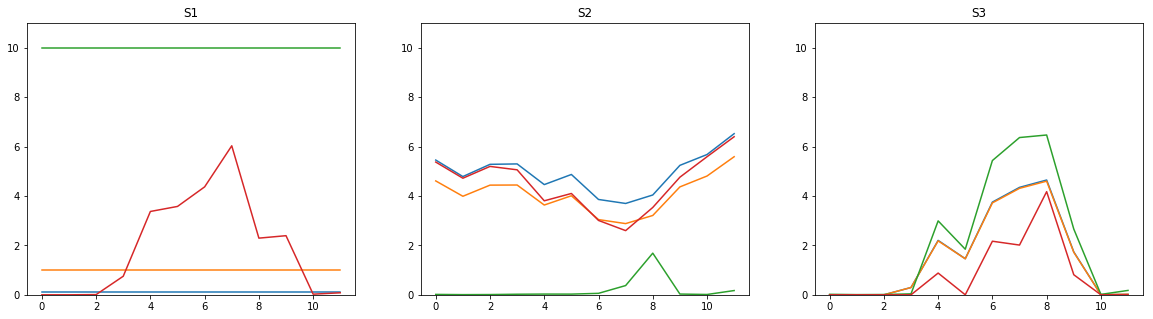

In [327]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

temp = np.c_[T_01[0], T_1[0], T_10[0], T_transfer[0]]
df = pd.DataFrame(temp)
df = df.rename(columns={0:"factor0, c=0.1", 1:"factor1, c=0.1", 2:"factor2, c=0.1", 
                        3:"factor0, c=1", 4:"factor1, c=1", 5:"factor2, c=1", 
                        6:"factor0, c=10", 7:"factor1, c=10", 8:"factor2, c=10",
                        9:"factor0, no constant", 10: "factor1, no constant", 11:"factor2, no constant"})
axes[0].plot(df.iloc[:, [0,3,6,9]])
axes[0].set_ylim(0, 11)
axes[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
axes[0].set_title("S1")
axes[1].plot(df.iloc[:, [1,4,7,10]])
axes[1].set_ylim(0, 11)
axes[1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
axes[1].set_title("S2")
axes[2].plot(df.iloc[:, [2,5,8,11]])
axes[2].set_ylim(0, 11)
axes[2].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
axes[2].set_title("S3")
# plt.savefig("./analysis/season.png", bbox_inches="tight", dpi=300)

In [128]:
H_a, A_a_const_10, T_a = learn_HAT_constant(10, case, au_tensor, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost) 
H_a, A_a_const_1, T_a = learn_HAT_constant(1, case, au_tensor, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost) 
H_a, A_a_const_01, T_a = learn_HAT_constant(0.1, case, au_tensor, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost) 


In [136]:
H_sd, A_sd, T_sd = learn_HAT(case, sd_tensor, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost) 
H_au, A_au, T_au = learn_HAT(case, au_tensor, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost) 

In [123]:
H_s, A_s_const_10, T_s = learn_HAT_constant(10, case, sd_tensor, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost) 
H_s, A_s_const_1, T_s = learn_HAT_constant(1, case, sd_tensor, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost) 
H_s, A_s_const_01, T_s = learn_HAT_constant(0.1, case, sd_tensor, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost) 


,c=0.1,c=1,c=10
hvac,0.000000,0.000000,0.0
fridge,0.863372,0.770285,0.0
mw,0.263008,0.200458,0.0
dw,0.321985,0.291197,0.0
wm,0.116320,0.116891,0.0
oven,0.309116,0.292714,0.0


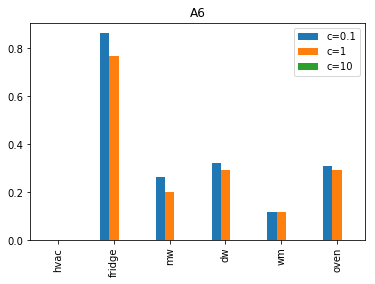

In [334]:
matrix = np.zeros((6, 3))
m = 0
n = 1
for i in range(1, 7):
    matrix[i-1][0] = A_a_const_01[i][m][n]
    matrix[i-1][1] = A_a_const_1[i][m][n]
    matrix[i-1][2] = A_a_const_10[i][m][n]
df = pd.DataFrame(matrix)
df = df.rename(index={0:"hvac", 1:"fridge", 2:"mw", 3:"dw", 4:"wm", 5:"oven"})
df = df.rename(columns={0: "c=0.1", 1:"c=1", 2:"c=10"})
df.plot(kind="bar", title="A6")
# plt.savefig("./analysis/A6.png", bbox_inches="tight", dpi=300)
df

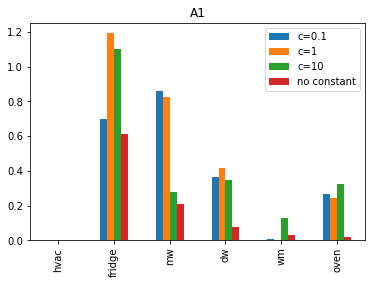

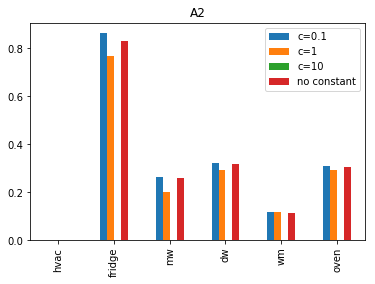

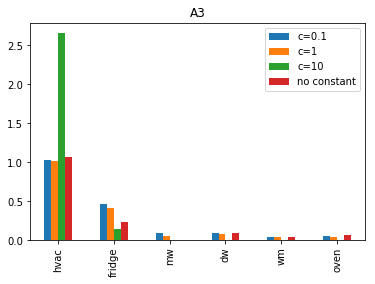

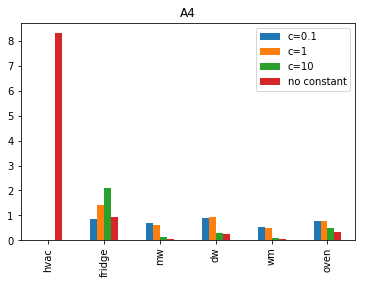

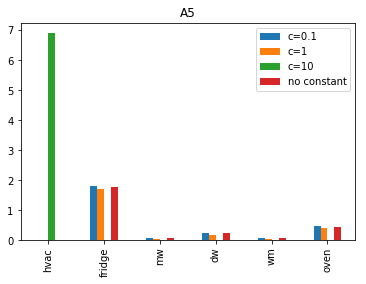

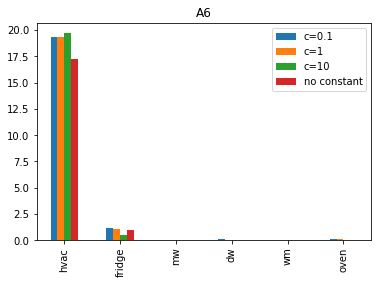

In [336]:
App_factor = {}
for i in range(6):
    App_factor[i+1] = np.zeros((6,4))
for m in range(2):
    for n in range(3):
        for j in range(1,7):
            App_factor[m*3+n+1][j-1][0] = A_a_const_01[j][m][n]
            App_factor[m*3+n+1][j-1][1] = A_a_const_1[j][m][n]
            App_factor[m*3+n+1][j-1][2] = A_a_const_10[j][m][n]
            App_factor[m*3+n+1][j-1][3] = A_au[j][m][n]
            
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,20))
# ax = axes.flatten()
count = 0

for idx in range(1,7):
    app = App_factor[idx].copy()
    df = pd.DataFrame(app)
    df = df.rename(index={0:"hvac", 1:"fridge", 2:"mw", 3:"dw", 4:"wm", 5:"oven"})
    df = df.rename(columns={0: "c=0.1", 1:"c=1", 2:"c=10", 3:"no constant"})
#     ax[count] = df.plot(kind="bar", title = "A" + str(idx))
    df.plot(kind="bar", title = "A" + str(idx))

## Compare Appliance factor of Austin and SanDiego

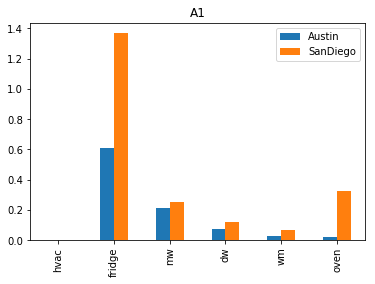

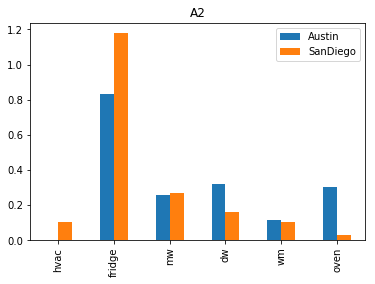

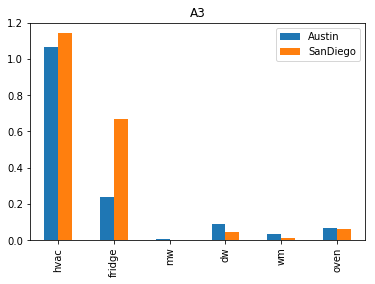

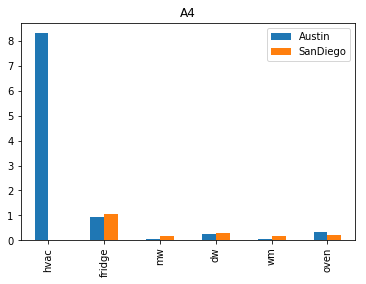

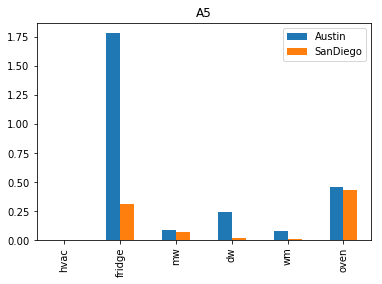

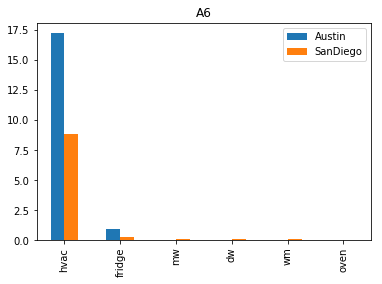

In [337]:
App_factor = {}
for i in range(6):
    App_factor[i+1] = np.zeros((6,2))
for m in range(2):
    for n in range(3):
        for j in range(1,7):
            App_factor[m*3+n+1][j-1][0] = A_au[j][m][n]
            App_factor[m*3+n+1][j-1][1] = A_sd[j][m][n]
            
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,20))
# ax = axes.flatten()
count = 0

for idx in range(1,7):
    app = App_factor[idx].copy()
    df = pd.DataFrame(app)
    df = df.rename(index={0:"hvac", 1:"fridge", 2:"mw", 3:"dw", 4:"wm", 5:"oven"})
    df = df.rename(columns={0:"Austin", 1:"SanDiego"})
#     ax[count] = df.plot(kind="bar", title = "A" + str(idx))
    df.plot(kind="bar", title = "A" + str(idx))


In [338]:
T_sd

array([[ 2.7373918 ,  5.483737  ,  0.        ],
       [ 2.51474511,  4.73472896,  0.        ],
       [ 3.42995343,  4.35415882,  0.        ],
       [ 4.47318013,  3.00934251,  0.56585557],
       [ 3.30831757,  2.5911144 ,  4.70036959],
       [ 5.80414166,  0.2621231 ,  2.99336574],
       [ 2.42841363,  2.36701749,  8.02668915],
       [ 3.21304334,  1.15030641,  9.06045135],
       [ 1.99887471,  3.15250419,  9.88394306],
       [ 4.01488298,  3.21894855,  3.64208518],
       [ 4.08702319,  4.0930259 ,  0.10978917],
       [ 5.31206824,  3.98835299,  0.0492658 ]])

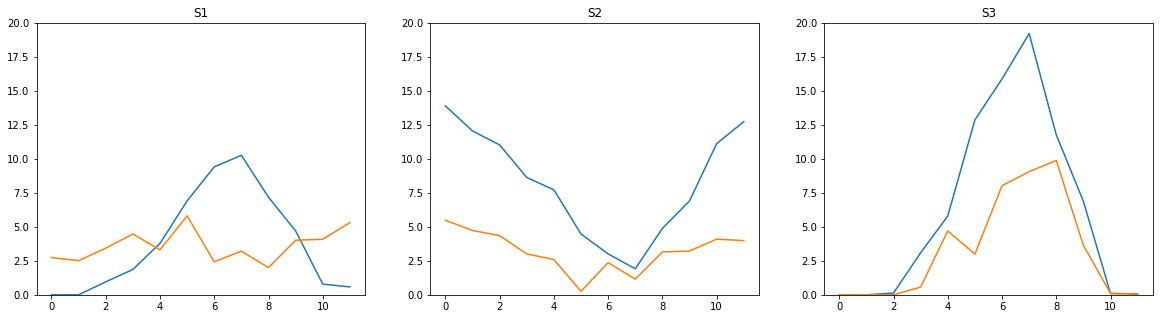

In [340]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

temp = np.c_[T_au, T_sd]
df = pd.DataFrame(temp)
df = df.rename(columns={0:"factor0, Austin", 1:"factor1, Austin", 2:"factor2, Austin", 
                        3:"factor0, SanDiego", 4:"factor1, SanDiego", 5:"factor2, SanDiego"})
axes[0].plot(df.iloc[:, [0,3]])
axes[0].set_ylim(0, 20)
axes[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
axes[0].set_title("S1")
axes[1].plot(df.iloc[:, [1,4]])
axes[1].set_ylim(0, 20)
axes[1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
axes[1].set_title("S2")
axes[2].plot(df.iloc[:, [2,5]])
axes[2].set_ylim(0, 20)
axes[2].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
axes[2].set_title("S3")
# plt.savefig("./analysis/season.png", bbox_inches="tight", dpi=300)

In [234]:
df = pd.DataFrame(A_a_const_10[idx][0], index={"F0", "F1", "F2"}, columns={"hvac"}).T
# df['Type'] = "const=10"
df
# df.plot(kind="bar")

,F0,F1,F2
hvac,1.104001,0.0,0.139441


In [230]:
idx = 2

In [231]:
A_a_const_10[idx]

array([[ 1.1040008 ,  0.        ,  0.13944119],
       [ 2.11870915,  0.        ,  0.47833449]])

In [232]:
A_a_const_1[idx]

array([[ 1.19263933,  0.77028484,  0.41329387],
       [ 1.42394589,  1.71030405,  1.10075624]])

In [233]:
A_a_const_01[idx]

array([[ 0.69643106,  0.86337164,  0.45952758],
       [ 0.84054084,  1.80505844,  1.15563431]])

In [190]:
A_s_const_10[idx]

array([[ 0.41635511,  0.43642793,  0.        ],
       [ 1.38609834,  0.356097  ,  0.09253417]])

In [191]:
A_s_const_1[idx]

array([[ 1.67119758,  1.48424274,  0.83966205],
       [ 1.62376598,  0.661627  ,  0.29798918]])

In [192]:
A_s_const_01[idx]

array([[ 0.45696702,  1.72617727,  1.01279288],
       [ 0.81409157,  0.86884482,  0.42449303]])

In [193]:
A_au[idx]

array([[ 0.61022038,  0.83029698,  0.24022591],
       [ 0.92088775,  1.78277796,  0.94253366]])

In [195]:
A_sd[idx]

array([[ 1.36778794,  1.17814111,  0.66708242],
       [ 1.06800783,  0.30968913,  0.26064357]])

In [196]:
T_sd

array([[ 2.7373918 ,  5.483737  ,  0.        ],
       [ 2.51474511,  4.73472896,  0.        ],
       [ 3.42995343,  4.35415882,  0.        ],
       [ 4.47318013,  3.00934251,  0.56585557],
       [ 3.30831757,  2.5911144 ,  4.70036959],
       [ 5.80414166,  0.2621231 ,  2.99336574],
       [ 2.42841363,  2.36701749,  8.02668915],
       [ 3.21304334,  1.15030641,  9.06045135],
       [ 1.99887471,  3.15250419,  9.88394306],
       [ 4.01488298,  3.21894855,  3.64208518],
       [ 4.08702319,  4.0930259 ,  0.10978917],
       [ 5.31206824,  3.98835299,  0.0492658 ]])

In [197]:
T_au

array([[  0.        ,  13.90138238,   0.        ],
       [  0.        ,  12.05786363,   0.        ],
       [  0.95320932,  11.0285244 ,   0.12927699],
       [  1.86498648,   8.63431318,   3.09438969],
       [  3.78151056,   7.72682179,   5.79330533],
       [  6.91206724,   4.47190388,  12.86430352],
       [  9.41421113,   3.01055611,  15.88328143],
       [ 10.26468081,   1.91437148,  19.22171172],
       [  7.17813595,   4.8817975 ,  11.77164584],
       [  4.69987472,   6.90835911,   6.87723134],
       [  0.78753444,  11.12058126,   0.09121452],
       [  0.58042052,  12.73992901,   0.06972975]])